In [19]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from evaluation import plot_comulated_returns
from evaluation import multiple_period_evaluation
import random as python_random
from sklearn import preprocessing
from tensorflow.keras import initializers
from tcn import TCN

# set the same seed to improve reproducibility
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
daily_returns = pd.read_csv("daily_returns.csv",index_col=0,parse_dates=True)
closing_prices = pd.read_csv("closing_prices.csv",index_col=0,parse_dates=True)

In [21]:
scaler = preprocessing.MinMaxScaler()
cum_returns = (1+daily_returns).cumprod(axis=0)-1
cum_returns = pd.DataFrame(scaler.fit_transform(cum_returns),index=cum_returns.index,columns=cum_returns.columns)
daily_return_scaled = pd.DataFrame(scaler.fit_transform(daily_returns),index=daily_returns.index,columns=daily_returns.columns)

In [22]:
df = pd.concat([daily_return_scaled,cum_returns],axis=1)
df

,N225,STOXX50E,NDX,GSPC,N225,STOXX50E,NDX,GSPC
Date,,,,,,,,
2013-01-02,0.676369,0.671167,0.610480,0.581920,0.740621,0.791738,0.031048,0.004064
2013-01-03,0.676369,0.594125,0.518370,0.512181,0.740621,0.793818,0.024324,0.000000
2013-01-04,0.620274,0.628794,0.531120,0.562949,0.719074,0.804189,0.019643,0.006639
2013-01-07,0.579210,0.517268,0.588477,0.538112,0.682024,0.787823,0.024001,0.008050
2013-01-08,0.646924,0.616645,0.539354,0.513487,0.670937,0.795271,0.020620,0.004254
...,...,...,...,...,...,...,...,...
2020-06-24,0.669483,0.329357,0.398117,0.344076,0.292133,0.249020,0.936741,0.815143
2020-06-25,0.675498,0.716343,0.641440,0.662020,0.291848,0.273363,0.957461,0.853204
2020-06-26,0.692793,0.433257,0.349158,0.330329,0.297206,0.244709,0.902627,0.793830


In [24]:
# hyperparams
batch_size = 5

train_test_split = 0.8

sequence_length = 125

epochs = 5

In [242]:
# generate target allocation to match
weights_list = []

from pypfopt import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting

# compute covariance matrix an all dataset for better approximation
S = CovarianceShrinkage(closing_prices).ledoit_wolf() 

# lower lookback yield target greater cumulative returns but makes allocation more volatile (not portfolio) 
# and harder to learn
price_lookback = 20

for index in range(sequence_length,closing_prices.shape[0]-1):
    sliced_prices = closing_prices.iloc[(index-sequence_length):(index)]
    mu = mean_historical_return(closing_prices.iloc[index-price_lookback:index+1])
    ef = EfficientFrontier(mu, S)
    try:
        weights = ef.max_sharpe()
        weights_list.append(weights)
    except:
        # equally weighted when the problem is infeasible
        weights_list.append({"N225":0.25,"STOXX50E":0.25,"NDX":0.25,"GSPC":0.25})
weightsA = np.array([list(weights.values()) for weights in weights_list]).round(2)
best_alloc = pd.DataFrame(weightsA,index=daily_returns.index[sequence_length:-1],columns=daily_returns.columns)

/home/fede/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [243]:
dates_intersection = daily_returns.index.intersection(best_alloc.index)
daily_returns_int = daily_returns.loc[dates_intersection]
best_alloc_int = best_alloc.loc[dates_intersection]
df = df.loc[dates_intersection]
returns_target = (daily_returns_int*best_alloc_int).sum(axis=1)
print("{} cumulated return target ".format((returns_target+1).prod()-1))
print("{} target std ".format(returns_target.std()))
print("{} target sharpe ".format(get_sharpe(daily_returns_int*best_alloc_int)))

3.3483132512457265 cumulated return target 
0.006497022031351817 target std 
4.487715778961435 target sharpe 


<AxesSubplot:xlabel='Date'>

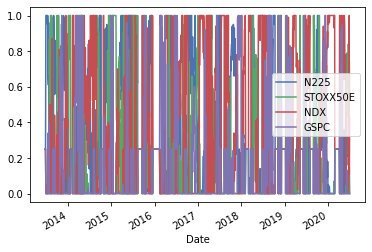

In [244]:
best_alloc.plot()

In [246]:
def get_tcn_yes_bias(sequence_length,output_size,num_features,tcn_dimension=32, kernel_size=3, skip_connection=False):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = TCN(tcn_dimension,kernel_size=kernel_size,use_skip_connections=skip_connection,activation='relu',kernel_initializer=initializers.RandomNormal(seed=1))(inputs)
    x = layers.Dense(output_size,kernel_initializer=initializers.RandomNormal(seed=1))(x)
    x = tf.nn.softmax(x)
    return keras.Model(inputs=inputs, outputs=x, name="allocationN")

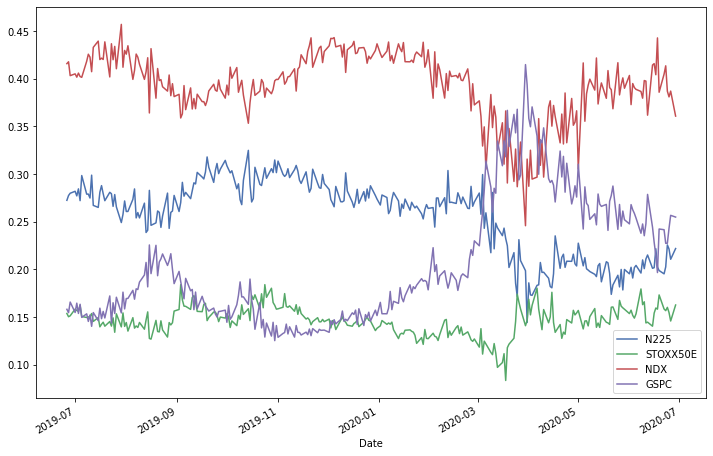

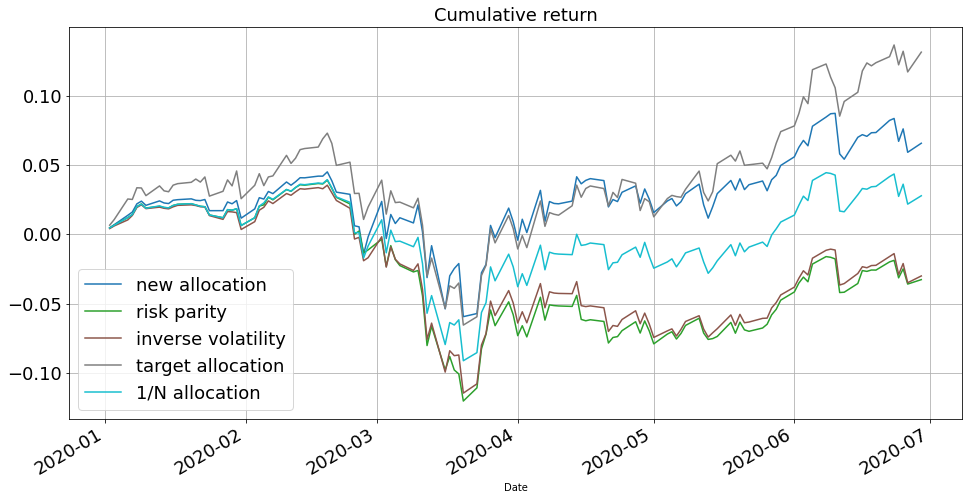

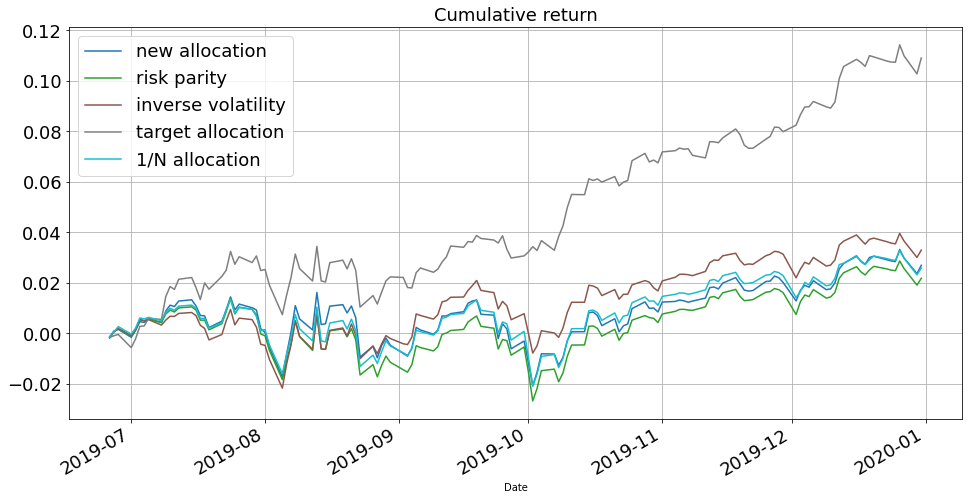

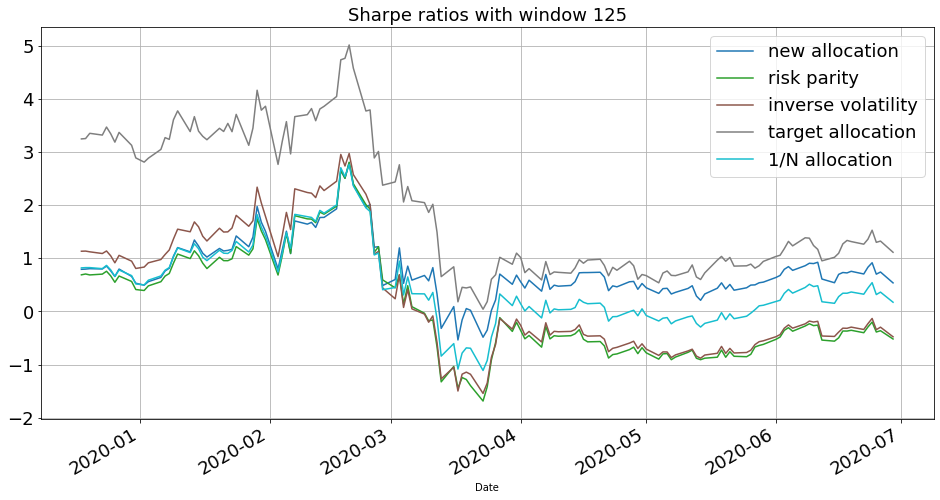

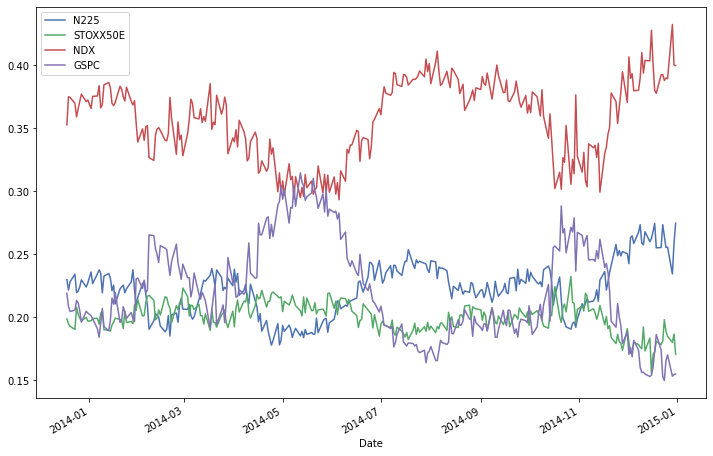

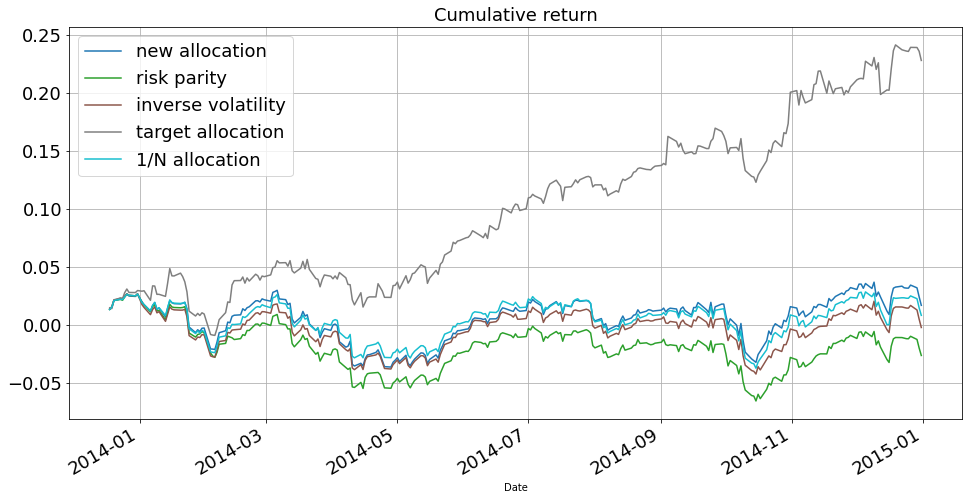

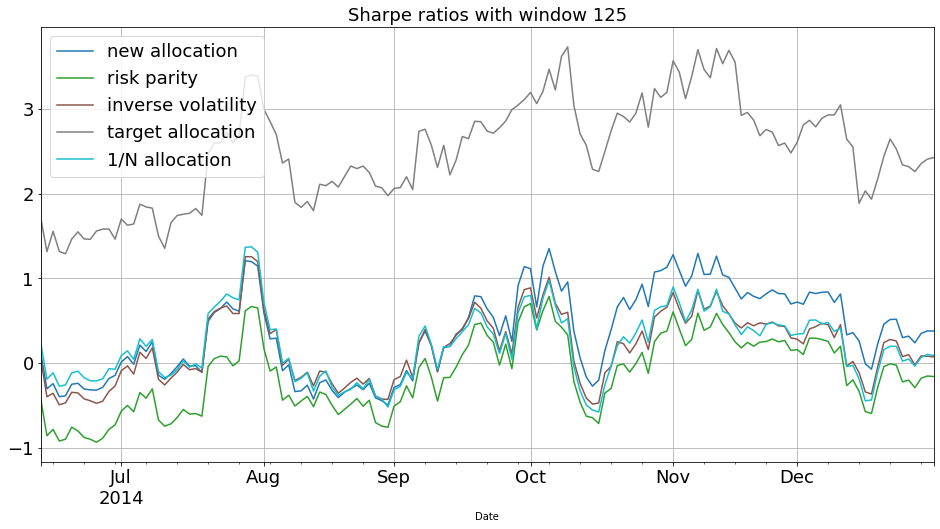

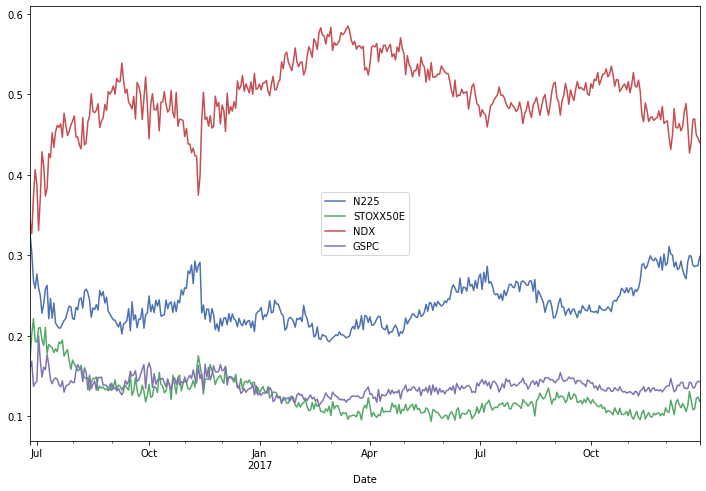

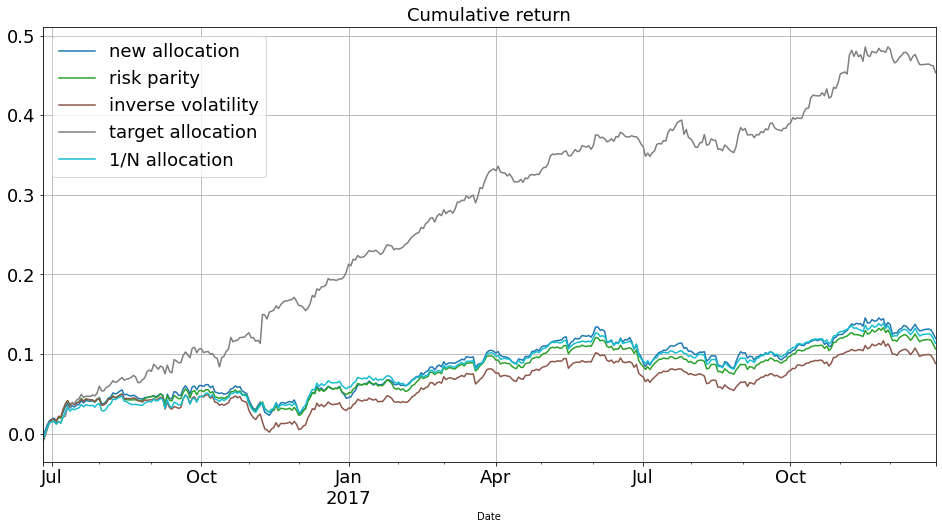

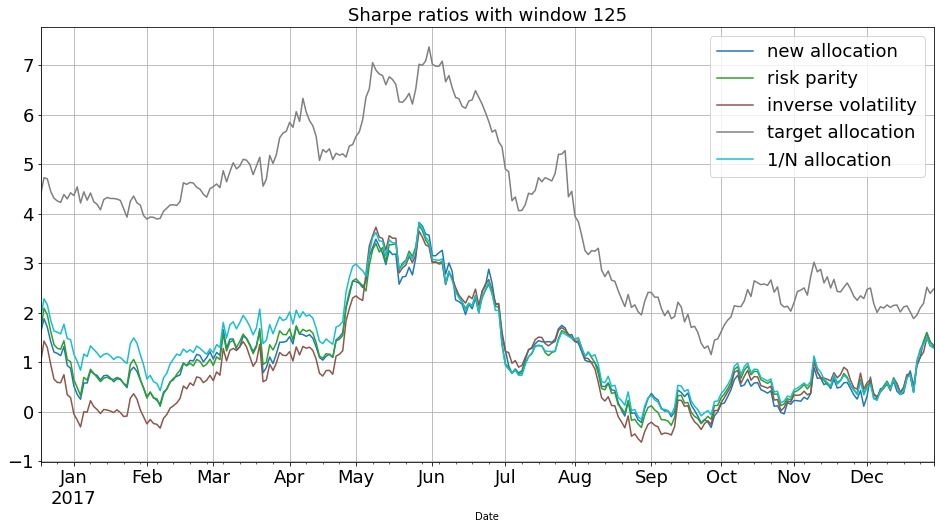

0.07700752586364919

In [248]:
model = get_tcn_yes_bias(sequence_length,4,df.shape[-1])
multiple_period_evaluation(model,df,best_alloc,daily_returns,plots=True)